# CMIP plots


# Setup

In [1]:
import os
import shutil
import glob
import pandas as pd
import numpy as np
import xarray as xr
import pickle as pkl

import cartopy
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.path as mpath

import cmocean.cm as cmo

import warnings
warnings.filterwarnings("ignore", message="Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range")

## Figure settings

In [2]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 120

# %config InlineBackend.figure_formats = ['pdf']
%config InlineBackend.figure_formats = ['png']

## Load dictionaries

In [3]:
# Get the last 40 years of the 1% CO2 runs and the corresponding time period in piControl
with open('../pkl_files/period_l40_slice_in_pi.pkl', 'rb') as file:
    period_l40_slice_in_pi = pkl.load(file)
with open('../pkl_files/period_l40_start_year_in_pi.pkl', 'rb') as file:
    period_l40_start_year_in_pi = pkl.load(file)
with open('../pkl_files/period_l40_end_year_in_pi.pkl', 'rb') as file:
    period_l40_end_year_in_pi = pkl.load(file)

with open('../pkl_files/period_l40_slice_in_co2.pkl', 'rb') as file:
    period_l40_slice_in_co2 = pkl.load(file)
with open('../pkl_files/period_l40_start_year_in_co2.pkl', 'rb') as file:
    period_l40_start_year_in_co2 = pkl.load(file)
with open('../pkl_files/period_l40_end_year_in_co2.pkl', 'rb') as file:
    period_l40_end_year_in_co2 = pkl.load(file)

    
# Get each model's variant_id
with open('../pkl_files/variant_id.pkl', 'rb') as file:
    variant_id = pkl.load(file)

## Create constants

In [6]:
# Cases / experiments
cases = ['piControl', '1pctCO2', '1pctCO2-rad', '1pctCO2-bgc']
cases_rad = ['1pctCO2', '1pctCO2-rad']


# Models with data in /tiger/scratch/gpfs/GEOCLIM/bgb2/CMIP/ and CMIPmerge/
# --> removed MRI-ESM2-0 because 1pctCO2 and 1pctCO2-rad Amon variables are the same

# --> models with HT, VEG for 1pctCO2 and 1pctCO2-rad (i.e., the max number of models used)
models = ['ACCESS-ESM1-5', 'BCC-CSM2-MR', 'CESM2', 'CMCC-ESM2',
          'CNRM-ESM2-1', 'EC-Earth3-CC', 'GFDL-ESM4', 'GISS-E2-1-G',
          'IPSL-CM6A-LR', 'MIROC-ES2L', 'MPI-ESM1-2-LR', 'NorESM2-LM',
          'UKESM1-0-LL']
#  --> models with HT, VEG, SW for all cases
models_all = ['ACCESS-ESM1-5', 'BCC-CSM2-MR', 'CMCC-ESM2',
              'CNRM-ESM2-1', 'GISS-E2-1-G', 'IPSL-CM6A-LR', 'MIROC-ES2L',
              'MPI-ESM1-2-LR', 'UKESM1-0-LL']
# --> only models with HT, VEG, SW for 1pctCO2 and 1pctCO2-rad
models_radsw = ['EC-Earth3-CC']
# --> only models with HT, VEG for 1pctCO2 and 1pctCO2-rad
models_rad = ['CESM2', 'GFDL-ESM4', 'NorESM2-LM']


# Variables
variables = ['evspsbl', 'hfls', 'hfss', 'lai', 'pr', 'prsn', 'ps', 'rlds', 
             'rlus', 'rlut', 'rsds', 'rsdt', 'rsus', 'rsut', 'ta', 'tas',
             'uas', 'vas']
variables_ht = ['hfls', 'hfss', 'pr', 'prsn', 'ps', 'rlds', 'rlus', 'rlut',
                'rsds', 'rsdt', 'rsus', 'rsut', 'ta']
variables_vegsw = ['evspsbl', 'lai', 'tas', 'uas', 'vas']
variables_veg = ['evspsbl', 'lai', 'tas']


# Table ID
table_id = {
    'areacella': 'fx',
    'evspsbl': 'Amon',
    'hfls': 'Amon',
    'hfss': 'Amon',
    'lai': 'Lmon',
    'pr': 'Amon',
    'prsn': 'Amon',
    'ps': 'Amon',
    'rlds': 'Amon', 
    'rlus': 'Amon',
    'rlut': 'Amon',
    'rsds': 'Amon',
    'rsdt': 'Amon',
    'rsus': 'Amon',
    'rsut': 'Amon',
    'sftlf': 'fx',
    'ta': 'Amon',
    'tas': 'Amon',
    'uas': 'Amon',
    'vas': 'Amon'
}


# Grid label
grid_label = {
    'ACCESS-ESM1-5': 'gn',
    'BCC-CSM2-MR': 'gn',
    'CESM2': 'gn',
    'CMCC-ESM2': 'gn',
    'CNRM-ESM2-1': 'gr',
    'EC-Earth3-CC': 'gr',
    'GFDL-ESM4': 'gr1',
    'GISS-E2-1-G': 'gn',
    'IPSL-CM6A-LR': 'gr',
    'MIROC-ES2L': 'gn',
    'MPI-ESM1-2-LR': 'gn',
    'MRI-ESM2-0': 'gn',
    'NorESM2-LM': 'gn',
    'UKESM1-0-LL': 'gn'
}


# Months
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
months_abbr = ['J','F','M','A','M','J','J','A','S','O','N','D']


# Directory where CMIP6 model output lives on tiger
cmipdir = '/tiger/scratch/gpfs/GEOCLIM/bgb2/CMIP/'
cmipmergedir = '/tiger/scratch/gpfs/GEOCLIM/bgb2/CMIPmerge/'

# Import data and preprocessing

In [19]:
%%time
def getcmippath(v, m, merge=True):
    if table_id[v] == 'fx':
        return cmipdir+m+'/'+v+'_'+table_id[v]+'_'+m+'_*_'+variant_id[m]+'_'+grid_label[m]+'.nc'
    elif merge:
        return cmipmergedir+m+'/'+v+'_'+table_id[v]+'_'+m+'_'+c+'_'+variant_id[m]+'_'+grid_label[m]+'.nc'
    elif not merge:
        return cmipdir+m+'/'+v+'_'+table_id[v]+'_'+m+'_'+c+'_'+variant_id[m]+'_'+grid_label[m]+'_*.nc'
    
## Set up dictionaries for storing data
pr = {}
evspsbl = {}
pe = {}

rsus = {}
rsds = {}
alb = {}

lai = {}
dlai_fr = {}

area = {}
lf = {}

for m in models:
    pr[m] = {'piControl': {}, '1pctCO2': {}, '1pctCO2-rad': {}, '1pctCO2-bgc': {}}
    evspsbl[m] = {'piControl': {}, '1pctCO2': {}, '1pctCO2-rad': {}, '1pctCO2-bgc': {}}
    pe[m] = {'piControl': {}, '1pctCO2': {}, '1pctCO2-rad': {}, '1pctCO2-bgc': {}}

    rsus[m] = {'piControl': {}, '1pctCO2': {}, '1pctCO2-rad': {}, '1pctCO2-bgc': {}}
    rsds[m] = {'piControl': {}, '1pctCO2': {}, '1pctCO2-rad': {}, '1pctCO2-bgc': {}}
    alb[m] = {'piControl': {}, '1pctCO2': {}, '1pctCO2-rad': {}, '1pctCO2-bgc': {}}
    
    lai[m] = {'piControl': {}, '1pctCO2': {}, '1pctCO2-rad': {}, '1pctCO2-bgc': {}}

## Retrieve the data
for m in models:
    tslice = period_l40_slice_in_co2[m]
    print(m)
    for c in cases_rad:
        print('  ',c)
        pr[m][c] = xr.open_dataset(getcmippath('pr', m))['pr'].sel(time=tslice) * 86400
        evspsbl[m][c] = xr.open_dataset(getcmippath('evspsbl', m))['evspsbl'].sel(time=tslice) * 86400
        pe[m][c] = pr[m][c] - evspsbl[m][c]
        
        rsus[m][c] = xr.open_dataset(getcmippath('rsus', m))['rsus'].sel(time=tslice)
        rsds[m][c] = xr.open_dataset(getcmippath('rsds', m))['rsds'].sel(time=tslice)
        alb[m][c] = rsus[m][c] / rsds[m][c]
        
        lai[m][c] = xr.open_dataset(getcmippath('lai', m))['lai'].sel(time=tslice)
    
    dlai_fr[m] = (lai[m]['1pctCO2'] - lai[m]['1pctCO2-rad']) / (lai[m]['1pctCO2'] + lai[m]['1pctCO2-rad'])
    # area[m] = xr.open_mfdataset(getcmippath('areacella', m))
    # lf[m] = xr.open_mfdataset(getcmippath('sftlf', m))
    

ACCESS-ESM1-5
   1pctCO2


/home/bgb2/miniconda3/envs/itcz_phys/lib/python3.11/site-packages/xarray/coding/times.py:152: SerializationWarning: Ambiguous reference date string: 101-01-01. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0101-01-01). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)
/home/bgb2/miniconda3/envs/itcz_phys/lib/python3.11/site-packages/xarray/coding/times.py:152: SerializationWarning: Ambiguous reference date string: 101-01-01. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0101-01-01). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)
/home/bgb2/miniconda3/envs/itcz_phys/lib/python3.11/site-packages/xarray/coding/times.py

   1pctCO2-rad


/home/bgb2/miniconda3/envs/itcz_phys/lib/python3.11/site-packages/xarray/coding/times.py:152: SerializationWarning: Ambiguous reference date string: 101-01-01. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0101-01-01). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)
/home/bgb2/miniconda3/envs/itcz_phys/lib/python3.11/site-packages/xarray/coding/times.py:152: SerializationWarning: Ambiguous reference date string: 101-01-01. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0101-01-01). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)
/home/bgb2/miniconda3/envs/itcz_phys/lib/python3.11/site-packages/xarray/coding/times.py

BCC-CSM2-MR
   1pctCO2
   1pctCO2-rad
CESM2
   1pctCO2
   1pctCO2-rad
CMCC-ESM2
   1pctCO2
   1pctCO2-rad
CNRM-ESM2-1
   1pctCO2
   1pctCO2-rad
EC-Earth3-CC
   1pctCO2
   1pctCO2-rad
GFDL-ESM4
   1pctCO2
   1pctCO2-rad
GISS-E2-1-G
   1pctCO2
   1pctCO2-rad
IPSL-CM6A-LR
   1pctCO2
   1pctCO2-rad
MIROC-ES2L
   1pctCO2
   1pctCO2-rad
MPI-ESM1-2-LR
   1pctCO2
   1pctCO2-rad
NorESM2-LM
   1pctCO2
   1pctCO2-rad
UKESM1-0-LL
   1pctCO2
   1pctCO2-rad
CPU times: user 28.5 s, sys: 20.4 s, total: 48.9 s
Wall time: 1min 41s


In [7]:
oceanmask = {}
for m in models:
    oceanmask[m] = xr.where(~np.isnan(lai[m]['1pctCO2'].isel(time=0)),1,0)
    
# Models with 
'EC-Earth3-CC'
'GFDL-ESM4'
'GISS-E2-1-G'
'NorESM2-LM'

# Visualization

## Maps

### ```P-E```

ACCESS-ESM1-5
BCC-CSM2-MR
CESM2
CMCC-ESM2
CNRM-ESM2-1
EC-Earth3-CC
GFDL-ESM4
GISS-E2-1-G
IPSL-CM6A-LR
MIROC-ES2L
MPI-ESM1-2-LR
NorESM2-LM
UKESM1-0-LL


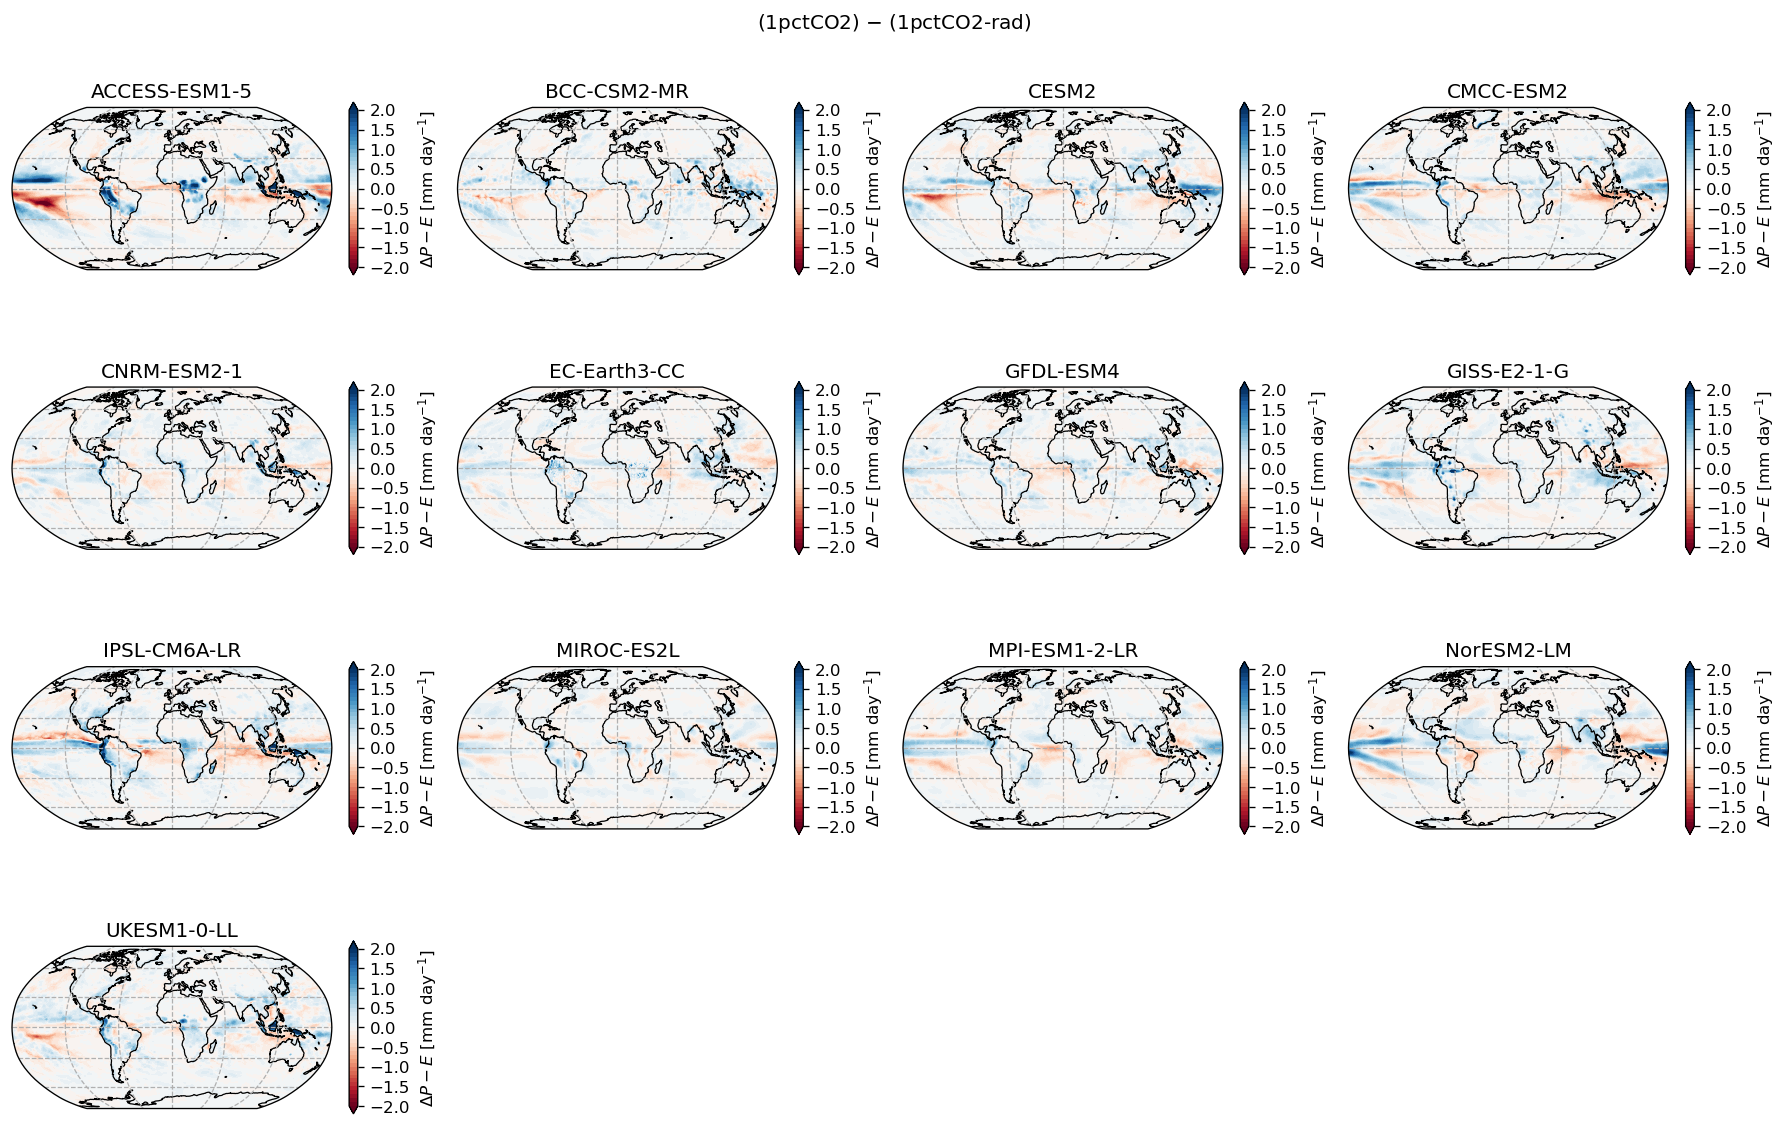

In [83]:
map_proj = ccrs.Robinson()

fig, axes = plt.subplots(4, 4, figsize=(15, 10), subplot_kw={'projection': map_proj})
ax = axes.flatten()

cb_range = np.arange(-2,2.1,0.1)

for ix, m in enumerate(models):
    print(m)
    ds = (pe[m]['1pctCO2'] - pe[m]['1pctCO2-rad']).mean(dim='time').squeeze()
    data, lon = add_cyclic_point(ds, coord=ds['lon'])

    cf = ax[ix].contourf(lon, ds['lat'], data, cb_range, cmap='RdBu', extend='both', transform=ccrs.PlateCarree())
    fig.colorbar(cf, ax=ax[ix], fraction=0.025, label='$\Delta P-E$ [mm day$^{-1}$]')
    ax[ix].set_title(m)

for a in ax:
    a.coastlines(linewidth=0.75)
    gl = a.gridlines(linewidth=0.75, linestyle='--')
    gl.xlocator = mticker.FixedLocator([-120, -60, 0, 60, 120, 180])
    gl.ylocator = mticker.FixedLocator([-60, -30, 0, 30, 60])
    
    _, y_btm = map_proj.transform_point(0, -90, ccrs.Geodetic())
    _, y_top = map_proj.transform_point(0, 90, ccrs.Geodetic())
    a.set_ylim(y_btm, y_top)
    
for a in ax[-3:]:
    a.remove()

fig.suptitle('(1pctCO2) $-$ (1pctCO2-rad)')
fig.tight_layout()

### Surface albedo

ACCESS-ESM1-5
BCC-CSM2-MR
CESM2
CMCC-ESM2
CNRM-ESM2-1
EC-Earth3-CC


/home/bgb2/miniconda3/envs/itcz_phys/lib/python3.11/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


GFDL-ESM4
GISS-E2-1-G
IPSL-CM6A-LR
MIROC-ES2L


/home/bgb2/miniconda3/envs/itcz_phys/lib/python3.11/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


MPI-ESM1-2-LR
NorESM2-LM
UKESM1-0-LL


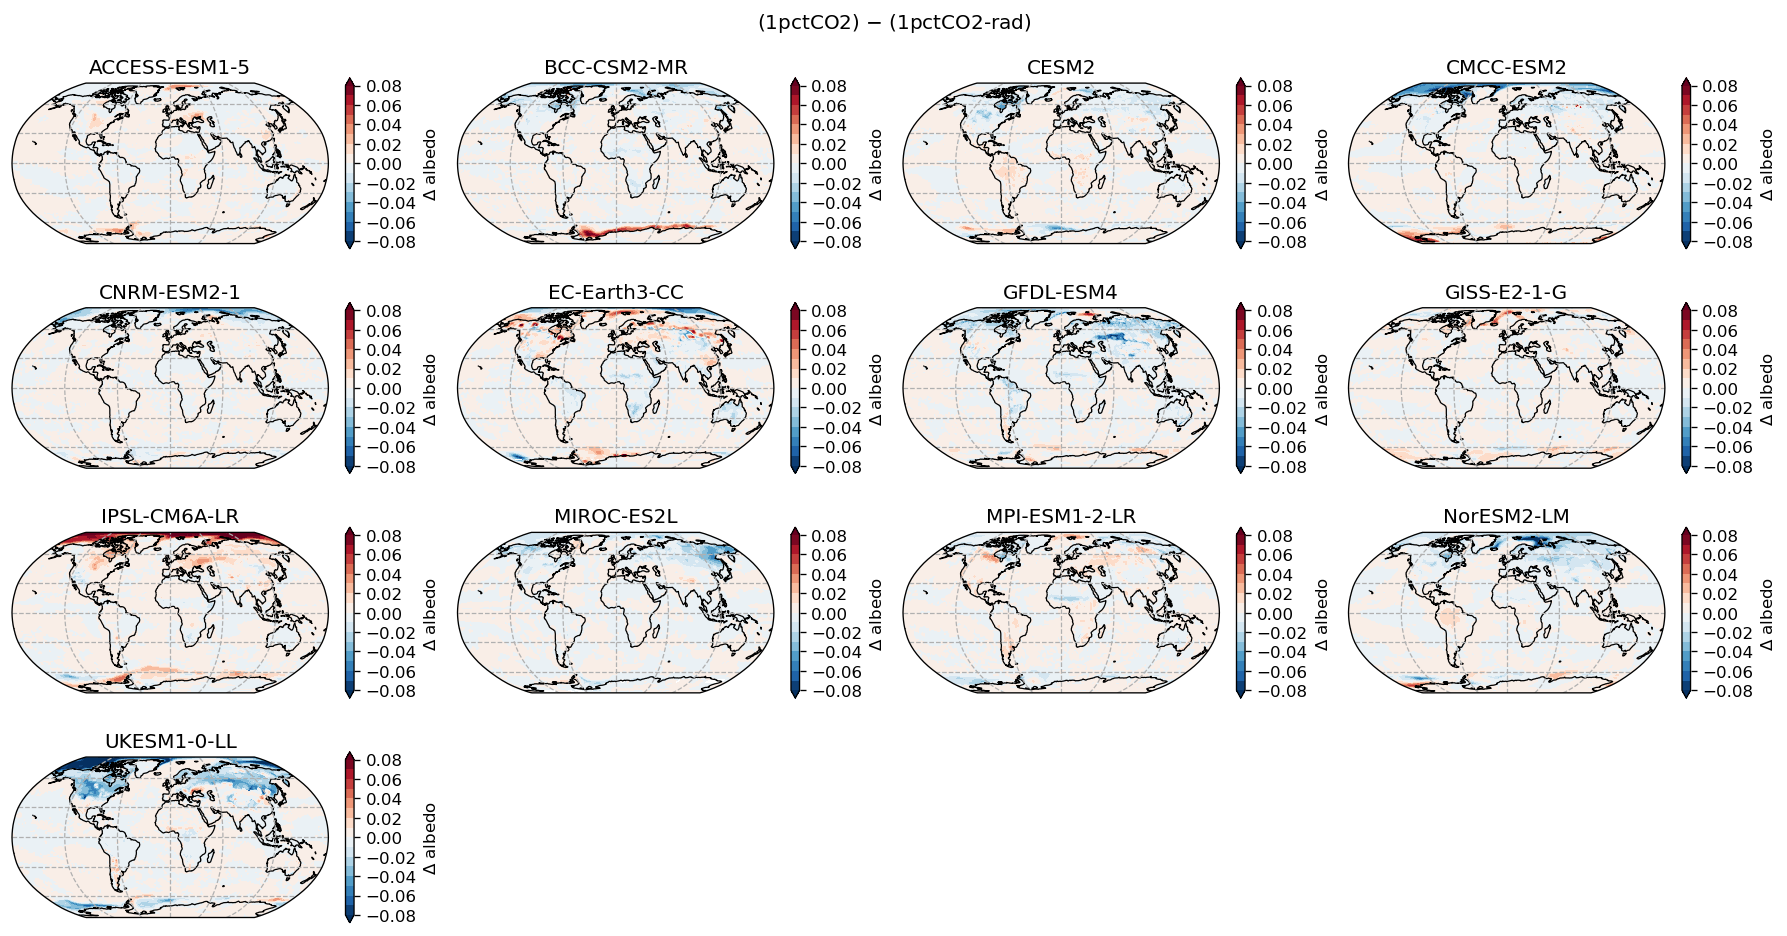

In [95]:
map_proj = ccrs.Robinson()

fig, axes = plt.subplots(4, 4, figsize=(15, 8), subplot_kw={'projection': map_proj})
ax = axes.flatten()

cb_range = np.arange(-0.08,0.081,0.01)

for ix, m in enumerate(models):
    print(m)
    ds = (alb[m]['1pctCO2'] - alb[m]['1pctCO2-rad']).mean(dim='time').squeeze()
    data, lon = add_cyclic_point(ds, coord=ds['lon'])

    cf = ax[ix].contourf(lon, ds['lat'], data, cb_range, cmap='RdBu_r', extend='both', transform=ccrs.PlateCarree())
    fig.colorbar(cf, ax=ax[ix], fraction=0.025, label='$\Delta$ albedo')
    ax[ix].set_title(m)

for a in ax:
    a.coastlines(linewidth=0.75)
    gl = a.gridlines(linewidth=0.75, linestyle='--')
    gl.xlocator = mticker.FixedLocator([-120, -60, 0, 60, 120, 180])
    gl.ylocator = mticker.FixedLocator([-60, -30, 0, 30, 60])
    
    _, y_btm = map_proj.transform_point(0, -90, ccrs.Geodetic())
    _, y_top = map_proj.transform_point(0, 90, ccrs.Geodetic())
    a.set_ylim(y_btm, y_top)
    
for a in ax[-3:]:
    a.remove()

fig.suptitle('(1pctCO2) $-$ (1pctCO2-rad)')
fig.tight_layout()

### ```LAI```

ACCESS-ESM1-5
BCC-CSM2-MR
CESM2
CMCC-ESM2
CNRM-ESM2-1
EC-Earth3-CC
GFDL-ESM4
GISS-E2-1-G
IPSL-CM6A-LR
MIROC-ES2L
MPI-ESM1-2-LR
NorESM2-LM
UKESM1-0-LL


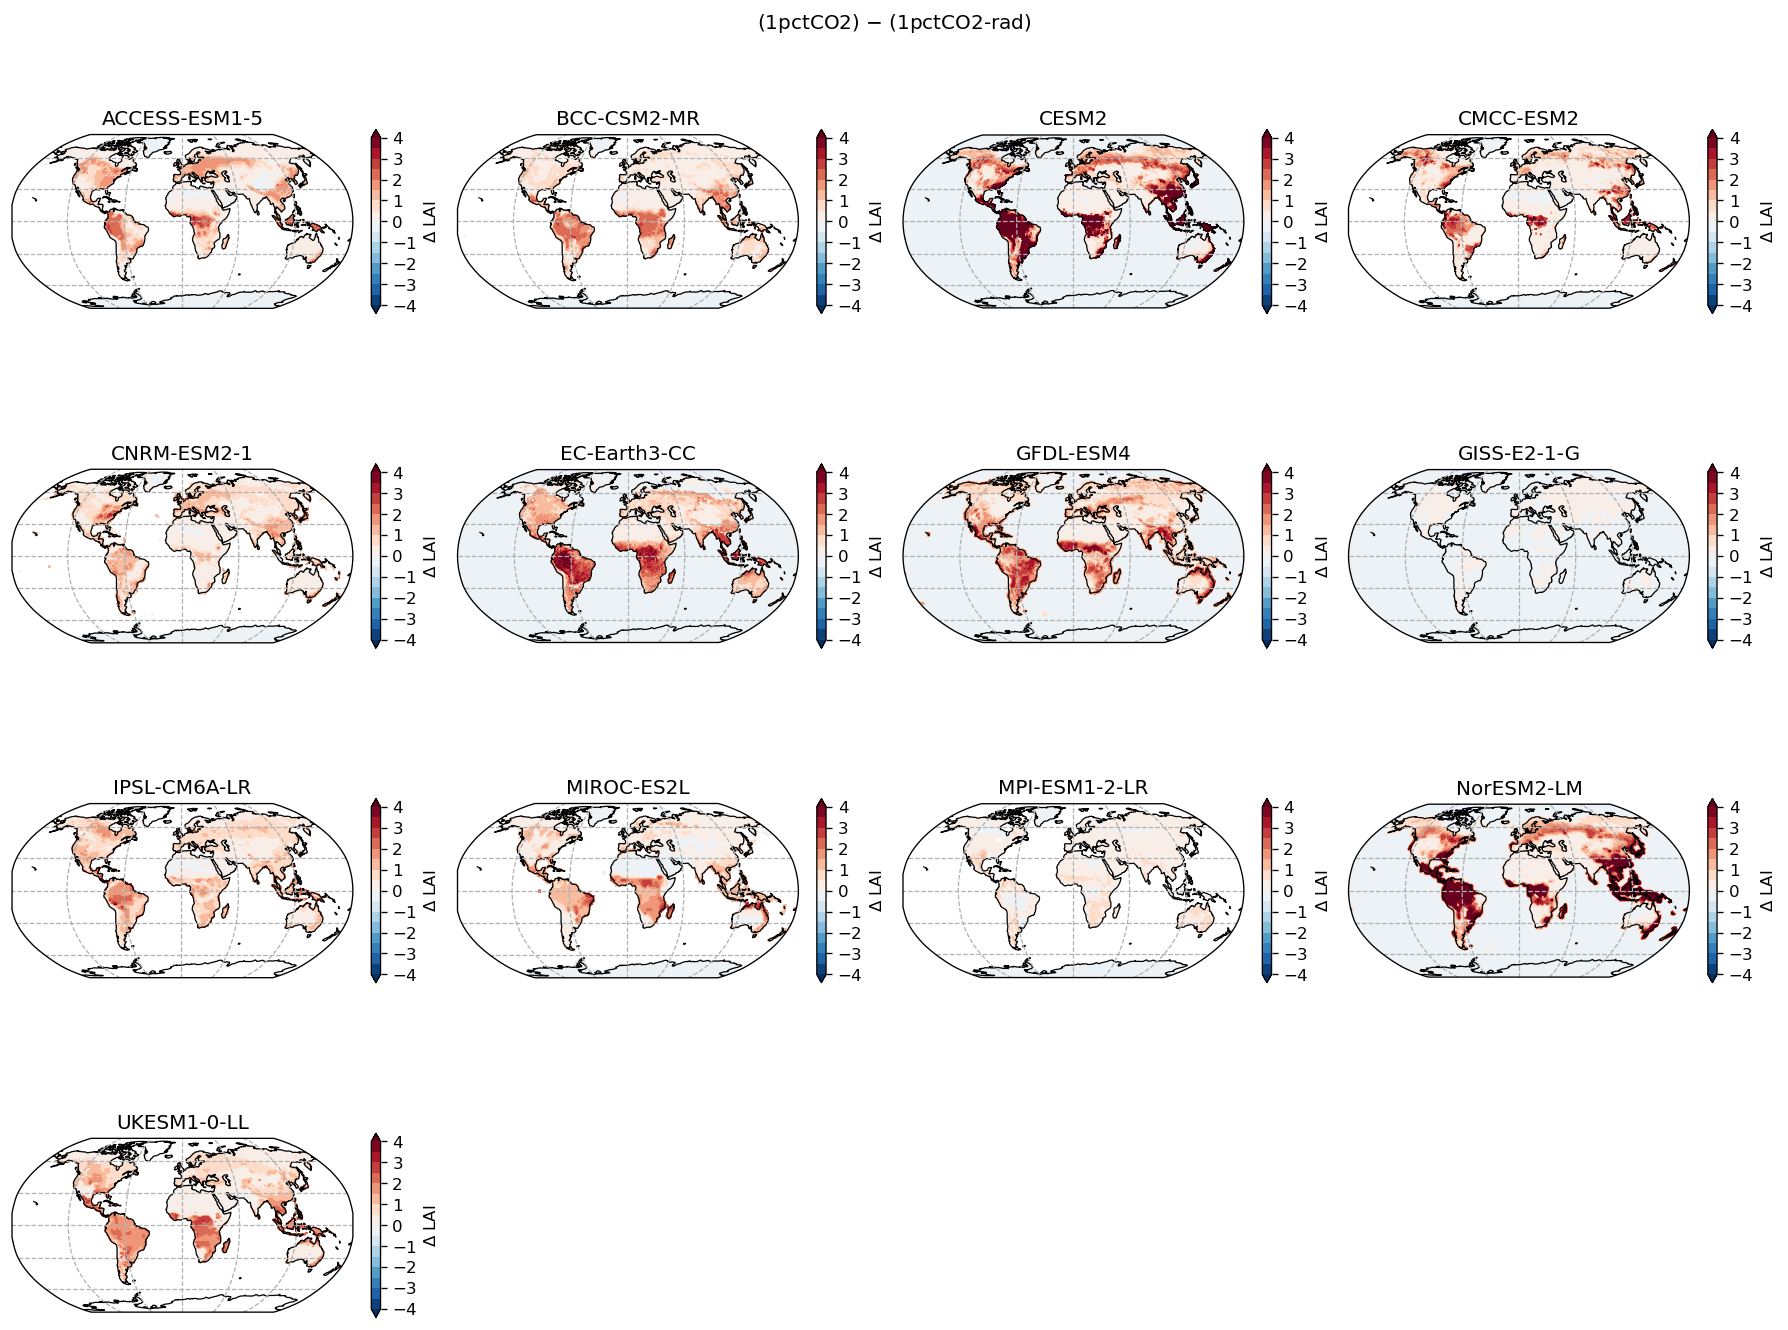

In [88]:
map_proj = ccrs.Robinson()

fig, axes = plt.subplots(4, 4, figsize=(15, 12), subplot_kw={'projection': ccrs.Robinson()})
ax = axes.flatten()

cb_range = np.arange(-4,4.1,0.5)

for ix, m in enumerate(models):
    print(m)
    ds = (lai[m]['1pctCO2'] - lai[m]['1pctCO2-rad']).mean(dim='time').squeeze().where(oceanmask[m]==1, )
    data, lon = add_cyclic_point(ds, coord=ds['lon'])

    cf = ax[ix].contourf(lon, ds['lat'], data, cb_range, cmap='RdBu_r', extend='both', transform=ccrs.PlateCarree())
    fig.colorbar(cf, ax=ax[ix], fraction=0.025, label='$\Delta$ LAI')
    ax[ix].set_title(m)

for a in ax:
    a.coastlines(linewidth=0.75)
    gl = a.gridlines(linewidth=0.75, linestyle='--')
    gl.xlocator = mticker.FixedLocator([-120, -60, 0, 60, 120, 180])
    gl.ylocator = mticker.FixedLocator([-60, -30, 0, 30, 60])

    _, y_btm = map_proj.transform_point(0, -90, ccrs.Geodetic())
    _, y_top = map_proj.transform_point(0, 90, ccrs.Geodetic())
    a.set_ylim(y_btm, y_top)

for a in ax[-3:]:
    a.remove()

fig.suptitle('(1pctCO2) $-$ (1pctCO2-rad)')
fig.tight_layout()

### ```fracLAI```

ACCESS-ESM1-5
BCC-CSM2-MR
CESM2
CMCC-ESM2
CNRM-ESM2-1
EC-Earth3-CC
GFDL-ESM4
GISS-E2-1-G
IPSL-CM6A-LR
MIROC-ES2L
MPI-ESM1-2-LR
NorESM2-LM
UKESM1-0-LL


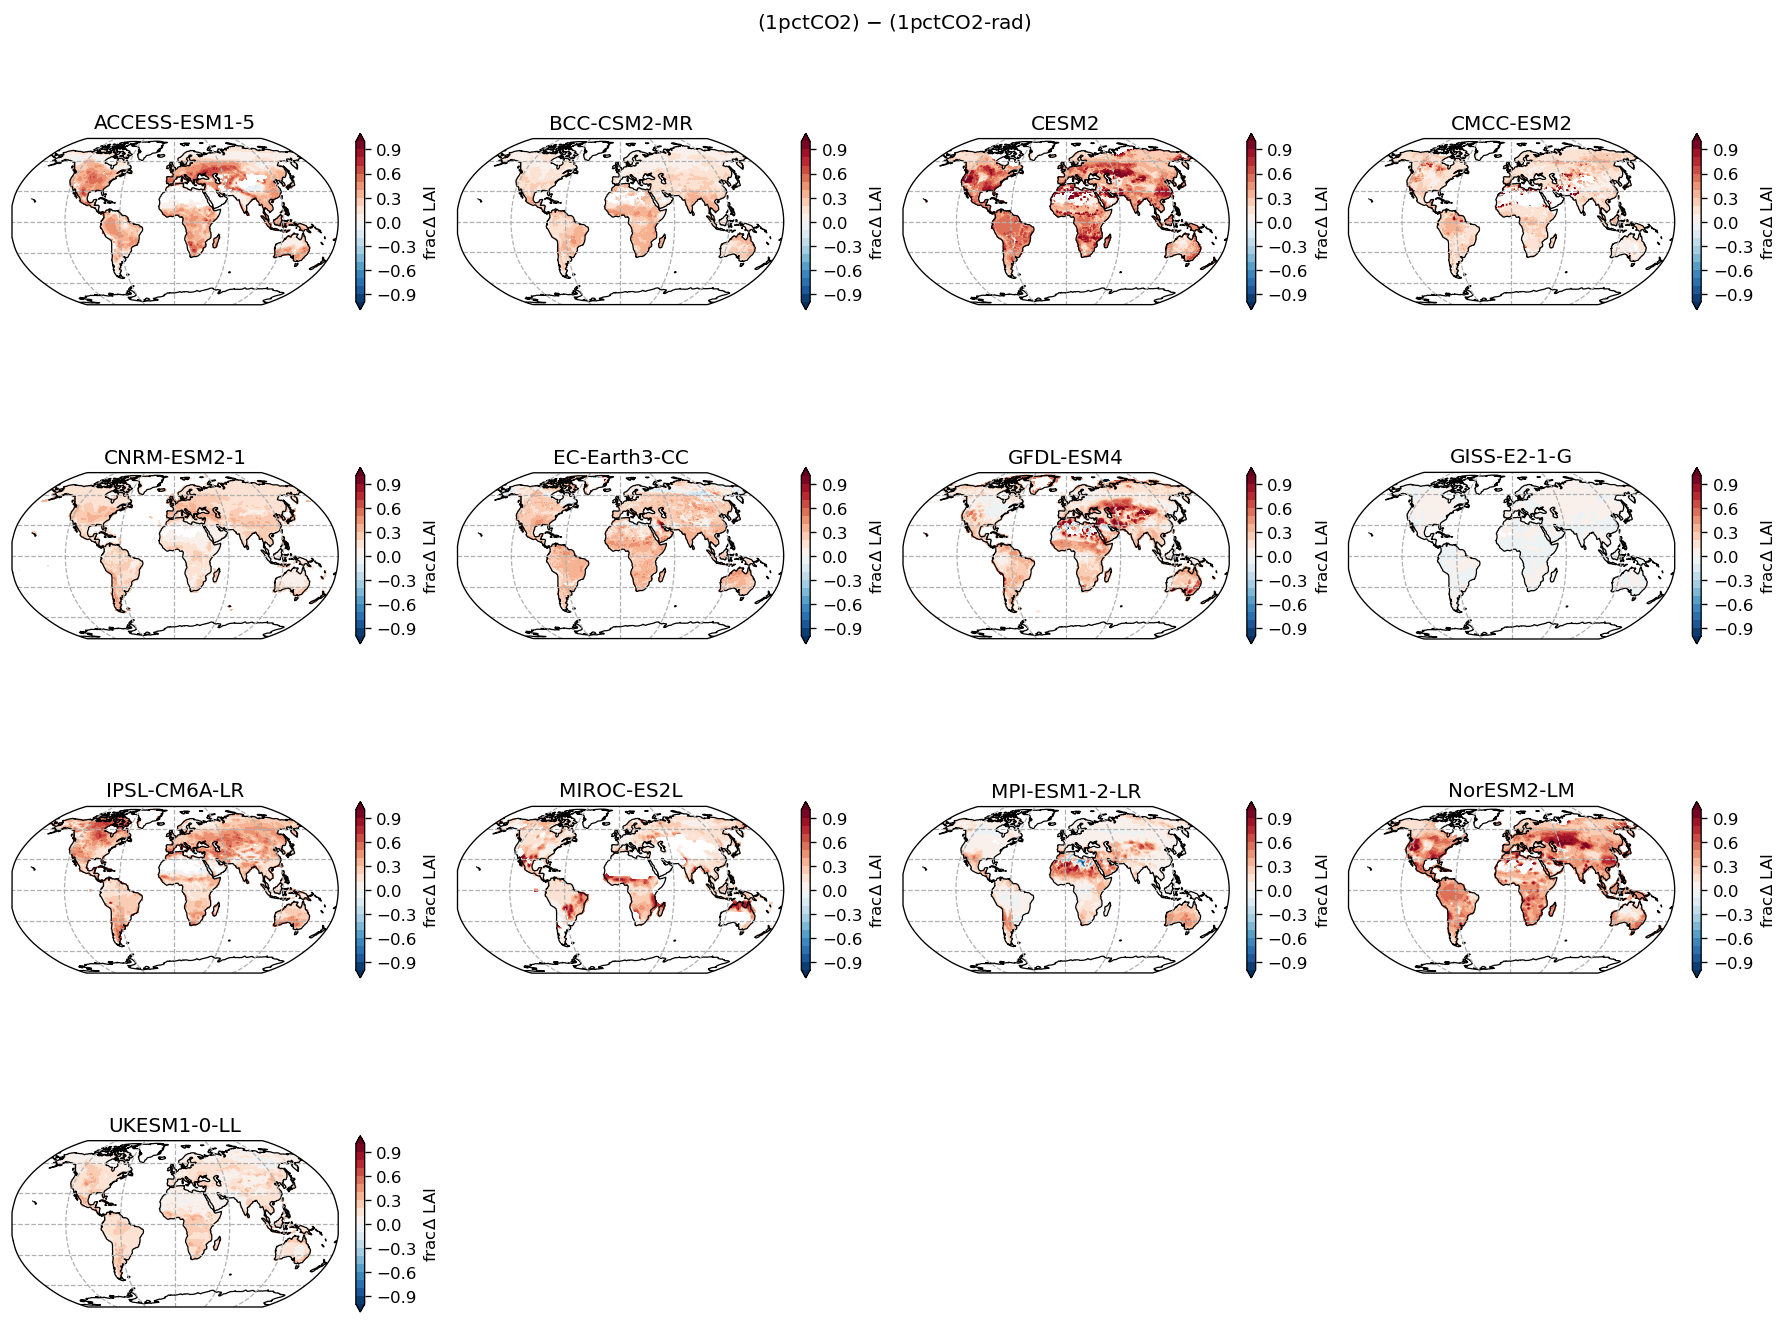

In [90]:
map_proj = ccrs.Robinson()

fig, axes = plt.subplots(4, 4, figsize=(15, 12), subplot_kw={'projection': ccrs.Robinson()})
ax = axes.flatten()

cb_range = np.arange(-1,1.1,0.1)

for ix, m in enumerate(models):
    print(m)
    ds = dlai_fr[m].mean(dim='time').squeeze().where(oceanmask[m]==1)
    data, lon = add_cyclic_point(ds, coord=ds['lon'])

    cf = ax[ix].contourf(lon, ds['lat'], data, cb_range, cmap='RdBu_r', extend='both', transform=ccrs.PlateCarree())
    fig.colorbar(cf, ax=ax[ix], fraction=0.025, label='frac$\Delta$ LAI')
    ax[ix].set_title(m)

for a in ax:
    a.coastlines(linewidth=0.75)
    gl = a.gridlines(linewidth=0.75, linestyle='--')
    gl.xlocator = mticker.FixedLocator([-120, -60, 0, 60, 120, 180])
    gl.ylocator = mticker.FixedLocator([-60, -30, 0, 30, 60])

    _, y_btm = map_proj.transform_point(0, -90, ccrs.Geodetic())
    _, y_top = map_proj.transform_point(0, 90, ccrs.Geodetic())
    a.set_ylim(y_btm, y_top)

for a in ax[-3:]:
    a.remove()

fig.suptitle('(1pctCO2) $-$ (1pctCO2-rad)')
fig.tight_layout()

## Zonal mean

In [6]:
for m in models:
    print(m)
    coslat = np.cos(np.deg2rad(pe[m]['piControl'].lat))
    for c in cases:
        print('   '+c)
        pe_zm[m][c] = (pe[m][c].mean(dim='lon') * coslat).load()

{'ACCESS-ESM1-5': 'r1i1p1f1',
 'BCC-CSM2-MR': 'r1i1p1f1',
 'CanESM5': 'r1i1p1f1',
 'CESM2': 'r1i1p1f1',
 'CMCC-ESM2': 'r1i1p1f1',
 'CNRM-ESM2-1': 'r1i1p1f2',
 'EC-Earth3-CC': 'r1i1p1f1',
 'GFDL-ESM4': 'r1i1p1f1',
 'GISS-E2-1-G': 'r101i1p1f1',
 'IPSL-CM6A-LR': 'r1i1p1f1',
 'MIROC-ES2L': 'r1i1p1f2',
 'MPI-ESM1-2-LR': 'r1i1p1f1',
 'MRI-ESM2-0': 'r1i2p1f1',
 'NorESM2-LM': 'r1i1p1f1',
 'UKESM1-0-LL': 'r1i1p1f2'}

NameError: name 'mcolors' is not defined

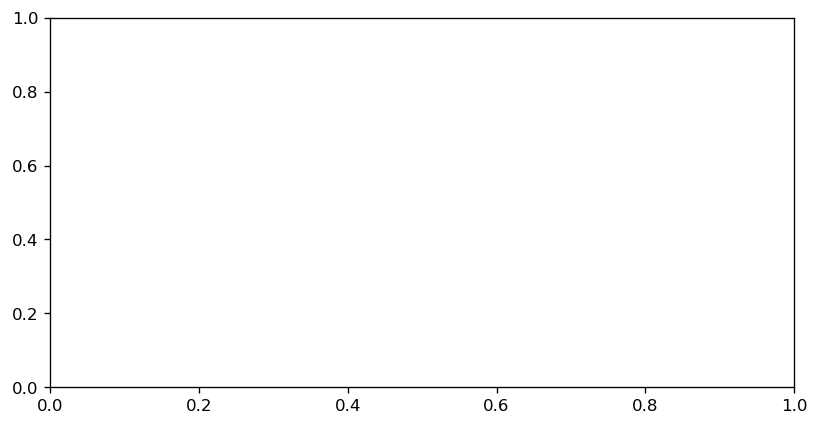

In [38]:
fig,ax = plt.subplots(figsize=(8,4))
xticks = np.sin(np.deg2rad([-80, -60, -40, -20, 0, 20, 40, 60, 80]))
xticklabels = ['80S', '60S', '40S', '20S', 'EQ', '20N', '40N', '60N', '80N']

for m in models:
    lat = pe[m]['1pctCO2'].lat
    coslat = np.cos(np.deg2rad(lat))
    sinlat = np.sin(np.deg2rad(lat))
    ax.plot(sinlat, pe[m]['1pctCO2'].mean(dim='lon')*coslat - pe[m]['1pctCO2-rad'].mean(dim='lon')*coslat,
            c=mcolors[m], lw=0.75, label=m)

ax.set_title('(%s)' % c)
ax.set_ylabel('$\Delta P-E$ [mm day$^{-1}$]')
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)
ax.set_xlim(-1,1)
ax.grid(c='k', ls=':', lw=0.5)

abs_ylim = 4
ax.set_ylim(-abs_ylim, abs_ylim)
ax.plot([-1,1], [0,0], c='k', lw=0.75, zorder=0)
ax.plot([0,0], [-abs_ylim,abs_ylim], c='k', lw=0.75, zorder=0)

leg = ax.legend(ncol=2, fontsize=6.5)
for line in leg.get_lines():
    line.set_linewidth(2.0)